In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#starting with some ML we need to import some more packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

#Try and model volatility based on some initial stock data
# The given data contains roughly 200 days, so closing prices for every trading day of the past year
    # for Microsoft, Tesla, S&P 500, and the DJIA

# Volatility Model phase 2 - Stocks

In the second phase of volatility modeling with stocks, we gathered a 10 year dataset of historical closing prices of 18 different major stocks.
- They are listed in the 10yrclosingpricesstocks.xlsx file to see

A lot has gone down in this starting with basically the same thing from phase 1 with a linear regression model.Then we moved into some more advanced things:
- averaged the dataset and performed another linear regression model to get a more readable look of the whole market's performance
- Next we applied PCA to select the most relevant predictors
- implemented GARCH and then improved the GARCH forecasts trying out EGARCH and other methods

In [23]:
#Next model with more data
# I gotten some more data from bloomberg - a diverse group of 18 stocks with 10 years of historical closing prices
stockgrp = pd.read_excel("10yrClosingPricesStocks.xlsx")
stockgrp = stockgrp.drop(columns=['Date'])

#volatility stuff
returns = np.log(stockgrp / stockgrp.shift(1))
volatility = returns.rolling(window=20).std() * np.sqrt(252)

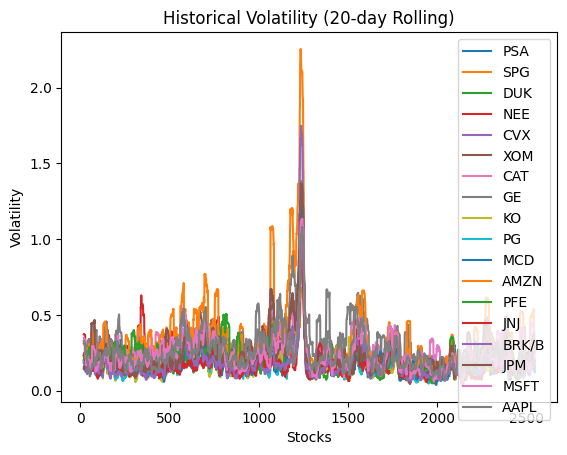

In [24]:


#plot volatility
plt.figure()
for col in volatility.columns:
    plt.plot(volatility.index, volatility[col], label=col)
plt.title("Historical Volatility (20-day Rolling)")
plt.xlabel("Stocks")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [25]:
#Gather a bit more data for the model
volatility_shifted = volatility.shift(-1) # predict next-day volatility
features = volatility.dropna()  #drop na data
target = volatility_shifted.dropna() #drop na data

#Align feature-target pairs
features, target = features.align(target, join='inner', axis=0)

# Define the split point (e.g., use the first 80% of data for training)
split_point = int(len(features) * 0.8)

# Train on past data, test on future data
X_train, X_test = features.iloc[:split_point], features.iloc[split_point:]
y_train, y_test = target.iloc[:split_point], target.iloc[split_point:]

In [26]:
#Prepare and train model
model = LinearRegression()
model.fit(X_train, y_train)

#predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00030163222471382543


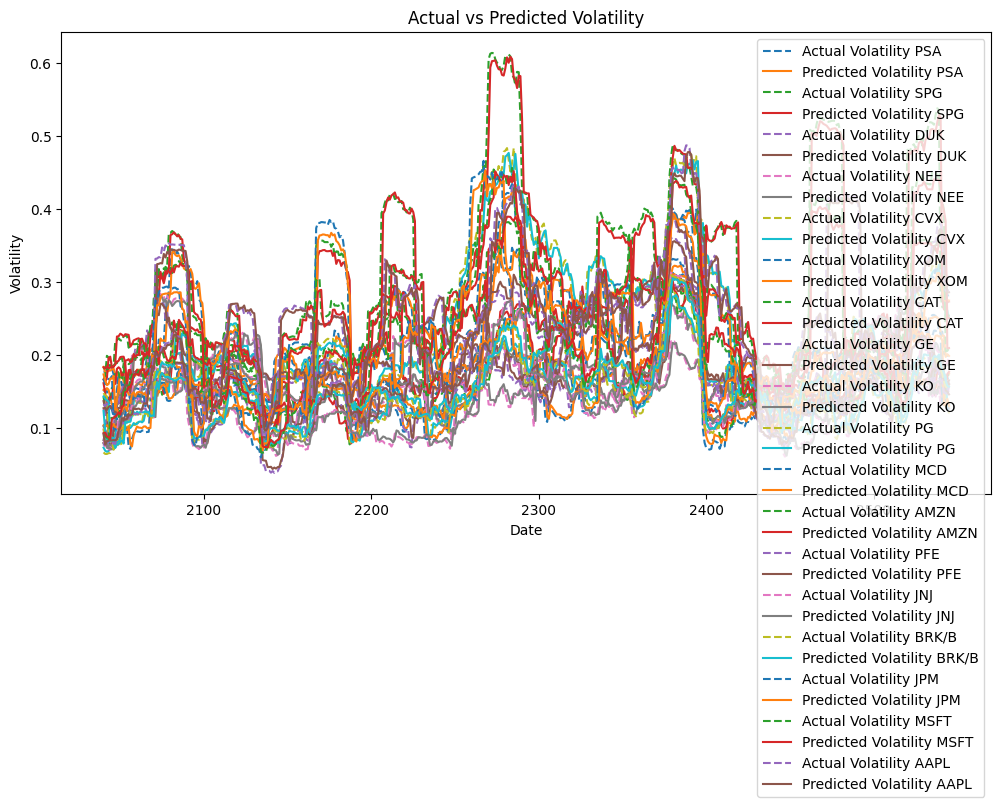

In [27]:
#ensure alignment
predictions_df = pd.DataFrame(predictions, index=y_test.index, columns=y_test.columns)

# Plot actual vs predicted volatility
plt.figure(figsize=(12, 6))
for col in y_test.columns:  # Loop over each stock column
    plt.plot(y_test.index, y_test[col], label=f'Actual Volatility {col}', linestyle='dashed')
    plt.plot(predictions_df.index, predictions_df[col], label=f'Predicted Volatility {col}')
plt.title("Actual vs Predicted Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

#trains off the first 2000 days of data and then predicts the next 500 days
# this graph shows the comparison between the prediction and the actual data

In [30]:
# Ensure alignment between predictions and y_test

# Calculate Mean Absolute Percentage Error (MAPE) for each stock
mae = (np.abs((y_test - predictions_df) / y_test)).mean()
print("Mean Absolute Error (MAE) for each stock:")
print(mae)

# Calculate Overall MAE (across all stocks)
overall_mae = (np.abs(y_test - predictions_df)).values.mean()
print(f"\nOverall Mean Absolute Error (MAE): {overall_mae:.4f}")

# Calculate R² (coefficient of determination) for the entire dataset
r2_score_overall = model.score(X_test, y_test)  # Use the full y_test (all columns)
print(f"\nOverall R² Score: {r2_score_overall:.4f}")

Mean Absolute Error (MAE) for each stock:
PSA      0.047899
SPG      0.058783
DUK      0.044765
NEE      0.047659
CVX      0.048930
XOM      0.048938
CAT      0.047304
GE       0.071242
KO       0.047059
PG       0.050031
MCD      0.050466
AMZN     0.054476
PFE      0.047872
JNJ      0.043953
BRK/B    0.045466
JPM      0.055165
MSFT     0.058973
AAPL     0.047839
dtype: float64

Overall Mean Absolute Error (MAE): 0.0091

Overall R² Score: 0.9379


The above graph is a little crazy - 10 years of data makes a huge difference in our ability to make predictions
- error has gone down and we just have a lot more data to work with

The issue is that we have 20 stocks now and it is super tricky to visualize it on a graph because of how chaotic it is

I have a couple options here
- first, would we be just to average out all the stock's volatilies - might as well just be predicting a volatility index
- other idea would be to break down into groups of stocks by sector - still kinda boring
- finally I could use perform a Principal Component Analysis to find the most important components to predicting volatility and just plot those!!!

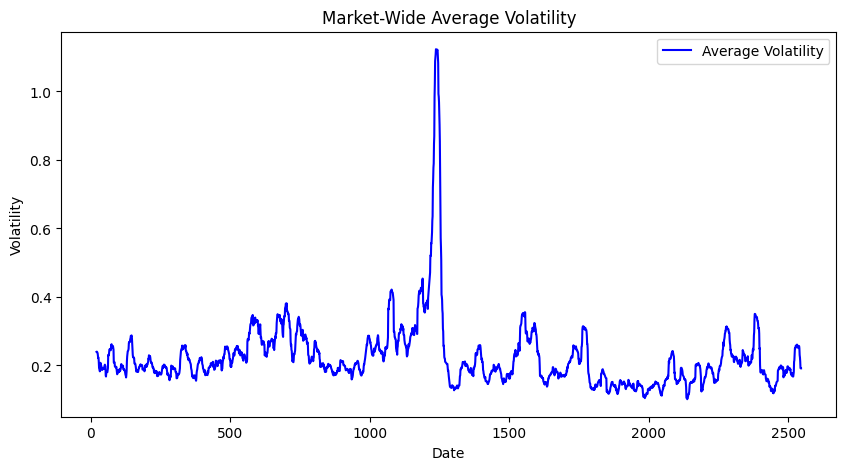

In [ ]:
#Average stocks into a volatility index
avg_volatility = volatility.mean(axis=1)    #taking average volatility down here and will be modeling that as well
avg_volatility = avg_volatility.to_frame()

# Plot it
plt.figure(figsize=(10,5))
plt.plot(avg_volatility, label="Average Volatility", color="blue")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Market-Wide Average Volatility")
plt.legend()
plt.show()

In [9]:
#model
avg_volatility_shifted = avg_volatility.shift(-1) # predict next-day volatility
features = avg_volatility.dropna()  #drop na data
target = avg_volatility_shifted.dropna() #drop na data

#Align feature-target pairs
features, target = features.align(target, join='inner', axis=0)

# Define the split point (e.g., use the first 80% of data for training)
split_point = int(len(features) * 0.8)

# Train on past data, test on future data
X_train, X_test = features.iloc[:split_point], features.iloc[split_point:]
y_train, y_test = target.iloc[:split_point], target.iloc[split_point:]

In [12]:
#Prepare and train model
model = LinearRegression()
model.fit(X_train, y_train)

#predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.7f}")

Mean Squared Error: 0.0003016


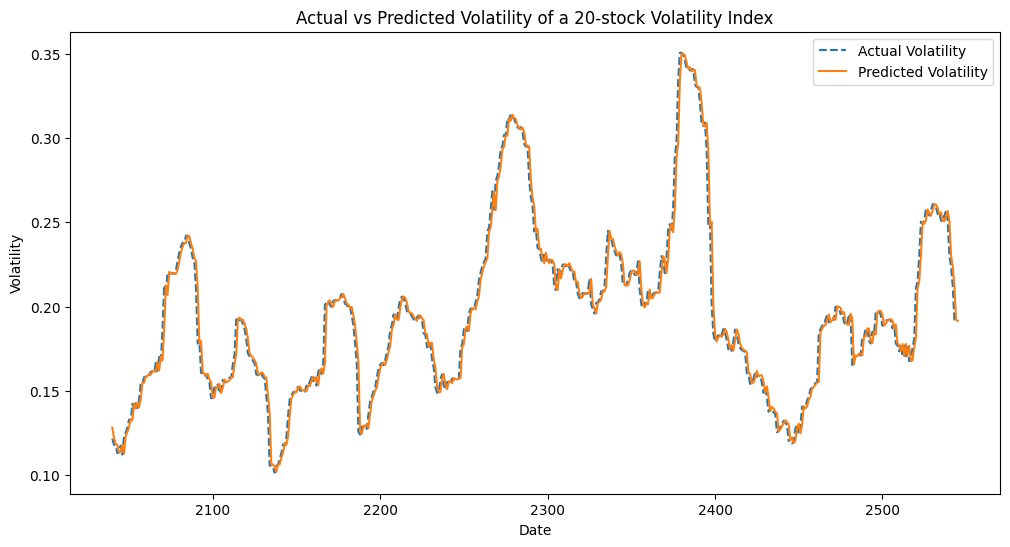

In [21]:
#ensure alignment
predictions_df = pd.DataFrame(predictions, index=y_test.index, columns=y_test.columns)

# Plot actual vs predicted volatility
plt.figure(figsize=(12, 6))
for col in y_test.columns:  # Loop over each stock column
    plt.plot(y_test.index, y_test[col], label=f'Actual Volatility', linestyle='dashed')
    plt.plot(predictions_df.index, predictions_df[col], label=f'Predicted Volatility')
plt.title("Actual vs Predicted Volatility of a 20-stock Volatility Index")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

We see here again that error decreases even more - I mean the prediction is near perfection.
- Error is so small its almost negligible
Its interesting to see here, but we have 10 years of data times 20 stocks averaged - this is just easy for a linear regression model to predict

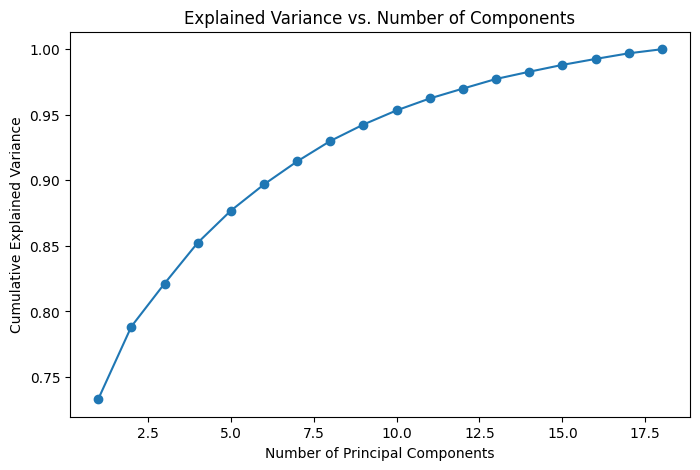

In [12]:
#Now I am going to try and mess around with a PCA to look at this data even more and see if we can try to see what stocks matter the most in determining the volatility

#first standardize data
std_volatility = (volatility - volatility.mean()) / volatility.std()
std_volatility = std_volatility.dropna() 

#PCA
pca = PCA(n_components=None)
principal_components = pca.fit_transform(std_volatility)

#This can tell us how many principal components we need to use
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.show()

#We will want to have about 90% of the total energy of the decomposition
#These will be the most impactful pieces and the rest will only be fine tuning since we already have a good base

In [13]:
#Im thinking about 6 components to get us to roughly 90% energy/variance
pca = PCA(n_components=6)
princ_comp = pca.fit_transform(std_volatility)

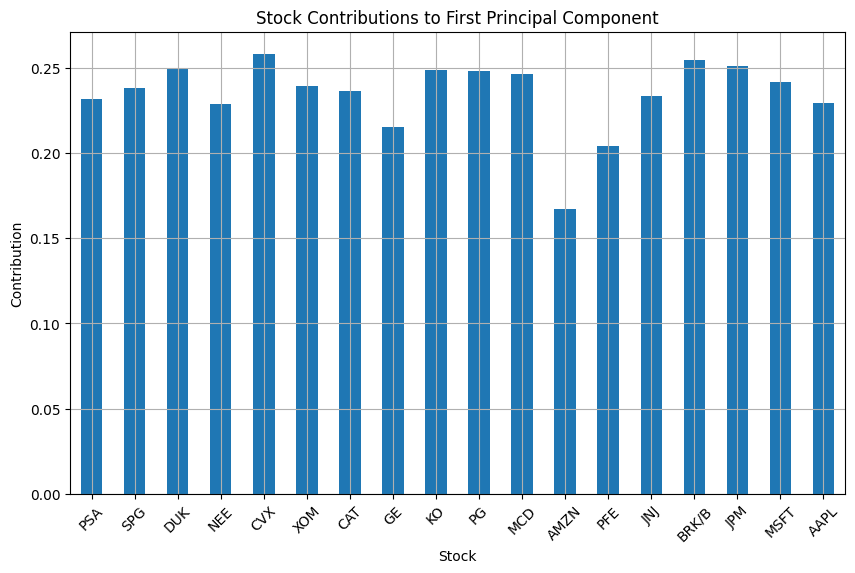

In [14]:
# Get PCA component loadings (impact of each stock on components) - go through each princ comp to see the differences
loadings = pd.DataFrame(pca.components_.T, 
                        index=std_volatility.columns, 
                        columns=[f"PC{i+1}" for i in range(pca.n_components_)])

# Plot first few principal components' stock contributions
plt.figure(figsize=(10,6))
loadings.iloc[:,0].plot(kind='bar')  # PC1
plt.title("Stock Contributions to First Principal Component")
plt.ylabel("Contribution")
plt.xlabel("Stock")
plt.xticks(rotation=45)
plt.grid()
plt.show()

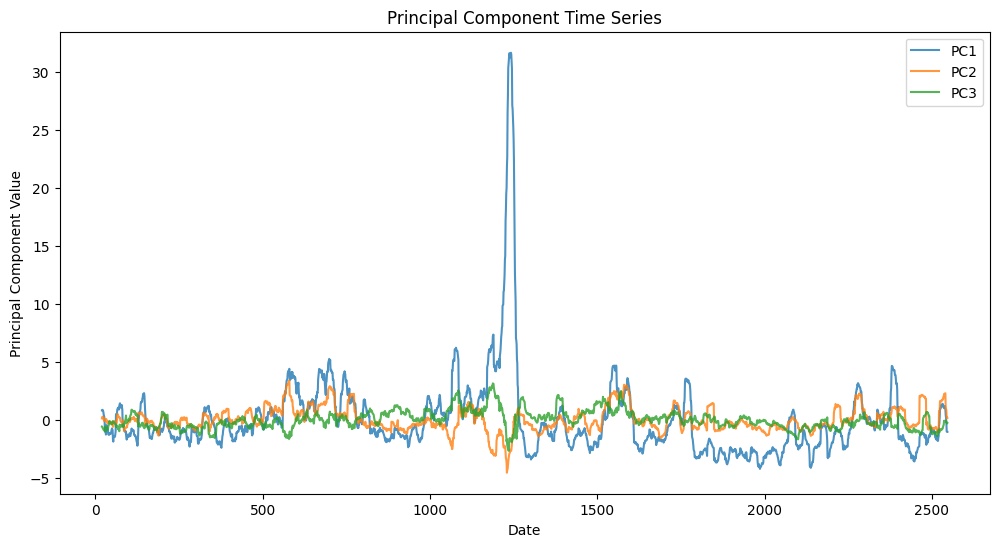

In [15]:
plt.figure(figsize=(12,6))

# First Principal Component
plt.plot(std_volatility.index, princ_comp[:,0], label="PC1", alpha=0.8)

# Optional: Add Second Component for Comparison
plt.plot(std_volatility.index, princ_comp[:,1], label="PC2", alpha=0.8)

# Optional: Add Second Component for Comparison
plt.plot(std_volatility.index, princ_comp[:,2], label="PC3", alpha=0.8)

plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.title("Principal Component Time Series")
plt.legend()
plt.show()

I ended up not using the PCA to predict because I was having a lot of issues, but it can tell us the importance of stocks in determining the volatility trends
- from the first graph we can see that it does take a decent amount of principal components to get up to 90% variance (6 principal components)
- from the next graph we can go through each princ comp and see what impact each stocks have on them
- The last graph just shows each principal components and its values over time

### GARCH Model

PCA and Linear Regression can capture relationships across stocks, but they don't explicitly model the time-dependent volatility clustering seen in financial markets. A GARCH model is frequently used to forecast future volatility based on past volatility trends. Let's try it!

In [16]:
from arch import arch_model

#rescale y
y_train_scaled = y_train*10

#Fit a GARCH model on best volatility predictor
garch = arch_model(y_train_scaled.mean(axis=1), vol='Garch', p=3, q=3)
garch_fitted = garch.fit()
print(garch_fitted.summary())

Iteration:      1,   Func. Count:     10,   Neg. LLF: 6742009293657158.0
Iteration:      2,   Func. Count:     25,   Neg. LLF: 2941707.660608327
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1455.6729345664296
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2995.9902121375744
Iteration:      5,   Func. Count:     56,   Neg. LLF: 2519033.22012005
Iteration:      6,   Func. Count:     66,   Neg. LLF: 1092.2664384881953
Iteration:      7,   Func. Count:     76,   Neg. LLF: 1194.6984988697145
Iteration:      8,   Func. Count:     86,   Neg. LLF: 1204.4126963200301
Iteration:      9,   Func. Count:     96,   Neg. LLF: 1247.8467225847007
Iteration:     10,   Func. Count:    106,   Neg. LLF: 1333.2340637117045
Iteration:     11,   Func. Count:    116,   Neg. LLF: 1442.4776887006692
Iteration:     12,   Func. Count:    126,   Neg. LLF: 797.4799138246772
Iteration:     13,   Func. Count:    135,   Neg. LLF: 1403.2542814592414
Iteration:     14,   Func. Count:    145,   Neg. LLF: 1

These values can tell us a lot about volatility for model we have trained:
- omega is the long-term variance and since it is so small (0.00268) it means volatility will stay low even if no shocks happen
- alpha is very high being so close to 1, which means recent shocks have a big impact on volatility
- beta is low being close to 0, which means that volatility does not persist for long after shocks

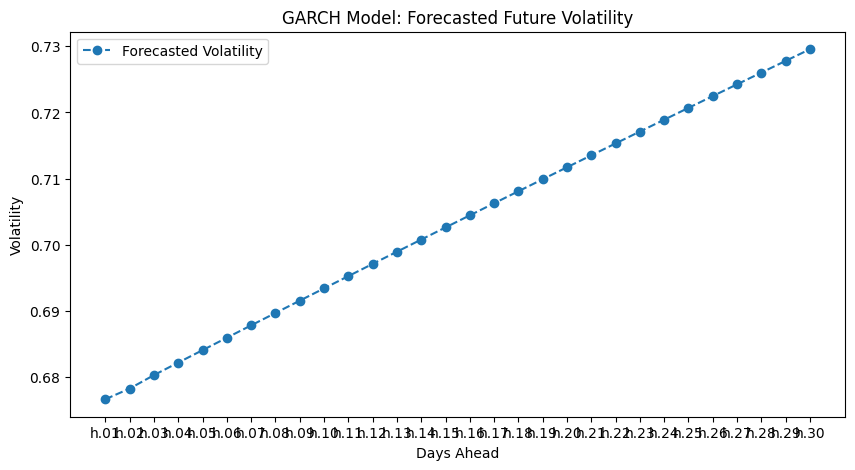

In [17]:
# forecast volatility
garch_forecast = garch_fitted.forecast(horizon=30)  #forecast 30 days ahead
predicted_volatility = garch_forecast.variance.iloc[-1] ** 0.5  #Convert variance to standard deviation

plt.figure(figsize=(10, 5))
plt.plot(predicted_volatility, marker='o', linestyle='dashed', label="Forecasted Volatility")
plt.xlabel("Days Ahead")
plt.ylabel("Volatility")
plt.title("GARCH Model: Forecasted Future Volatility")
plt.legend()
plt.show()

In [18]:
print("Last observed volatility:", y_train_scaled.iloc[-1])
print("First forecasted volatility:", predicted_volatility.iloc[0])

Last observed volatility: 0    1.278137
Name: 2039, dtype: float64
First forecasted volatility: 0.6766911954314597


This is showing up as a much different volatility scale than what we saw in our linear regression forecasting
- it seems to just continue to increase linearly forever
- it just is not right

we will try to adjust the parameters of the Garch model to see if we can fix it

In [19]:
#Fit a GARCH model on best volatility predictor
egarch = arch_model(y_train_scaled.mean(axis=1), vol='EGarch', p=2, q=2)
egarch_fitted = egarch.fit()
print(egarch_fitted.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6083740151299.6
Iteration:      2,   Func. Count:     19,   Neg. LLF: 32095873083599.715
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5394377512.158003
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1010599781.7288907
Iteration:      5,   Func. Count:     50,   Neg. LLF: 2169035131.648402
Iteration:      6,   Func. Count:     59,   Neg. LLF: 1267288764.7685893
Iteration:      7,   Func. Count:     68,   Neg. LLF: 832.4800495478873
Iteration:      8,   Func. Count:     75,   Neg. LLF: 840.7150220470612
Iteration:      9,   Func. Count:     83,   Neg. LLF: 823.877237241372
Iteration:     10,   Func. Count:     90,   Neg. LLF: 821.9629776989335
Iteration:     11,   Func. Count:     97,   Neg. LLF: 820.9764652032583
Iteration:     12,   Func. Count:    104,   Neg. LLF: 820.7197642563289
Iteration:     13,   Func. Count:    111,   Neg. LLF: 820.5833235605512
Iteration:     14,   Func. Count:    118,   Neg. LLF: 820.582620

Omega: -0.48515239104809227, Alpha: 1.5305815187364151, Beta: 0.8154975216842169


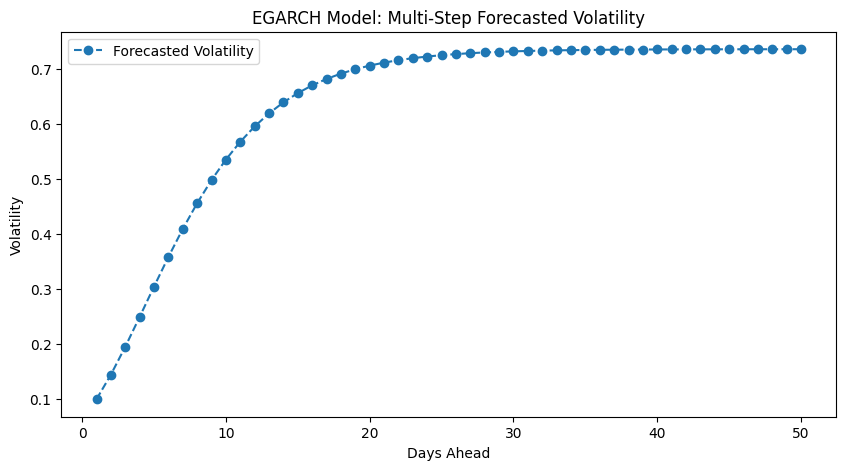

In [20]:
# Get model parameters
omega = egarch_fitted.params['omega']
alpha = egarch_fitted.params['alpha[1]']
beta = egarch_fitted.params['beta[1]']
gamma = egarch_fitted.params.get('gamma[1]', 0)  
print(f"Omega: {omega}, Alpha: {alpha}, Beta: {beta}")

# Initialize forecast storage
num_days = 50  # Forecasting 30 days ahead
forecasted_volatility = []

# Start forecasting from the last observed variance
last_log_variance = np.log(egarch_fitted.conditional_volatility.iloc[-1] ** 2)

#asymmetric shock term
expected_abs_z = np.sqrt(2 / np.pi)

# Threshold to prevent overflow
log_variance_threshold = 100

for _ in range(num_days):
    new_log_variance = omega + beta  * last_log_variance + alpha * expected_abs_z + gamma * expected_abs_z
    if new_log_variance > log_variance_threshold:
        new_log_variance = log_variance_threshold
    new_variance = np.exp(new_log_variance)
    forecasted_volatility.append(np.sqrt(new_variance))  # Convert variance to std dev
    last_log_variance = new_log_variance  # Update for next iteration

forecasted_volatility = np.array(forecasted_volatility) / 10

# Plot forecasted volatility
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_days + 1), forecasted_volatility, marker='o', linestyle='dashed', label="Forecasted Volatility")
plt.xlabel("Days Ahead")
plt.ylabel("Volatility")
plt.title("EGARCH Model: Multi-Step Forecasted Volatility")
plt.legend()
plt.show()

We see above that using the egarch model gets us an appropriate volatility forecast of our data.
- after only 20 or so days the volatility seems to converge around .7 and stick there
- this is the forecasted volatility of all the stock data compiled together

In the next file we want to look at some ML based models such as LSTM, GRU, and XGBoost